# Solving Tic Tac Toe Variants

## Abstract

niket do ur magic

## Problem Description

3x3 tic tac toe is easy, but due to the curse of dimensionality the state space grows much larger for 3x3x3 leading to a much more complex game. can these also be solved, and what is the most compute-efficient way in doing so?

## Related Work

Paper on n-dimensional tic-tac-toe with some useful theorems which we can use in our mathematical analysis: https://web.archive.org/web/20160429190326/http://library.msri.org/books/Book42/files/golomb.pdf

Might be useful:
https://www.math.ucdavis.edu/~linear/student_creations/TicTacToe.pdf


Monte carlo tree search paper:
https://www.aaai.org/Papers/AIIDE/2008/AIIDE08-036.pdf

Wikipedia articles with saucy stuff: 
https://en.wikipedia.org/wiki/Hales%E2%80%93Jewett_theorem
https://en.wikipedia.org/wiki/Nd_game#cite_note-:3-5

## Simplifications

In [1]:
from agent import RandomAgent
from sim import simulate

import numpy as np
import matplotlib.pyplot as plt
from tictactoe import Board2D

Random agent vs random agent analysis goes here!

## Mathematical Model

Here is where we introduce minimax. How does it work? What is its complexity? Etc etc

## Solution of the Mathematical Problem

In [2]:
from agent import MiniMaxAgent

Solve 3x3 tic tac toe

Introduce difficulties with 3x3x3 (depth issues!)

Introduce the notion of handcrafted heuristic eval with inductive bias to improve performance

Introduce MCTS as a more efficient way to search the state space

## Results

optimal minimax 3x3

performance of various heuristics in 3x3x3

minimax vs. mcts (daniel analysis)

alpha beta complexity/runtime analysis

### Monte Carlo Tree Search

In [3]:
# note to self; fact check this with OG paper

One alternative to Minimax search is Monte Carlo Tree Search, or MCTS (cite). The goal of MCTS is to assign a value to each position in the tree of possible moves. Instead of searching every position breadth-first with an evaluation function up until a certain depth, monte carlo tree search explores the game tree over a series of simulations and uses *random rollouts* to assign value to each node in the tree. Starting from some root node (e.g. the current game position), MCTS will simulate multiple traversals down the game tree. 

During each traversal, the exploration of already-seen positions brings up an interesting dilema: how do we balance exploring new positions with exploting the knowledge we already have about positions we've encountered more often? There's a balance to strike here: on the one hand, if you explore more positions you might learn something new and valuable which improves your tree's representation of the best possible moves. Yet on the other hand, exploring new positions might reinforce what you already know about the position, and it might be better to get a better understanding of the few good candidate moves by doing more rollouts on positions you already know are likely to be good. In order to solve this, MCTS uses a formula called UCB (upper confidence bound) to determine which already-seen node to traverse to:
$$S_i = x_i + C\sqrt{\frac{\ln(t)}{n_i}}$$

where $S_i$ is the value of node $i$, $x_i$ is the mean performance of all the rollouts stemming from that position, $C$ is a hyperparameter, $t$ is the total number of MCTS simulations, and $n_i$ is the number of times node $i$ has been visited across all simulations. The hyperparameter $C$ helps the user specify how much they want MCTS to explore new positions and how much it wants MCTS to explot its initial knowledge when choosing which child node to traverse to from the root. If $C$ is 0, then MCTS will only traverse to the nodes it sees with the highest win % (maximal $x_i$). However, if $C$ is nonzero, the $\sqrt{\frac{\ln(t)}{n_i}}$ will influence MCTS to explore positions it hasn't visited often (low $n_i$ $\implies$ higher $\sqrt{\frac{\ln(t)}{n_i}}$ since $t$ is a constant). For our experiments, we set $C$ = 0.1

In a given traversal, once MCTS has encountered a new position it hasn't seen before, it will compute random rollouts (games played until completion with random moves) and keep track of the result. This result will then be backpropgated to all the parent nodes to update their corresponding values. For example, if a node has two children, one with 5 wins and 5 losses from rollouts and another with 10 wins and 20 losses from rollouts, the value of the parent node will be $\frac{5 + 10}{5 + 20} = \frac{15}{25} = \frac{3}{5}$ (assuming a win has value 1).

**maybe include a graphic i make?**

The reason this method might be useful to us is because it's more computationally efficient than MiniMax. That is to say, for a fixed runtime budget, MCTS will look at more positions than MiniMax, as most of the positions it sees are the result of random rollouts, which lets it look at more positions much faster. It's able to gather information more efficiently than minimax is (on a fixed time budget). Because of this, it might interesting to compare MCTS to Minimax and see if its efficient use of the state information in the game tree will allow it to perform better than Minimax.

First, we can test MCTS against a random agent to see how the number of Monte Carlo Simulations affect performance

In [4]:
from agent import MonteCarloAgent
from utils import plot_agent_results

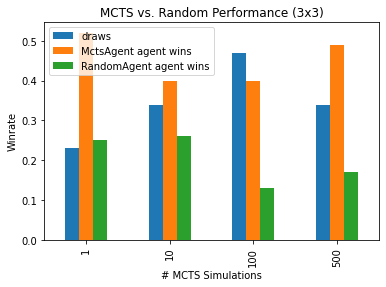

In [10]:
results = []
rand = RandomAgent()
sim_depth = [1, 10, 100, 500]
for mcts_sims in sim_depth:
    board = Board2D(board_size=3)
    mcts = MonteCarloAgent(num_sims=mcts_sims)
    res = simulate(board, mcts, rand, num_sims=100, display=False)
    results.append(res)
    
plot_agent_results(
    results,
    mcts,
    rand,
    x=sim_depth,
    title='MCTS vs. Random Agent (3x3)',
    xlabel='# MCTS Simulations',
    ylabel='Winrate'
)

From the plot, we can see that increasing the simulation depth seems to greatly affect performance against a random agent, as the random winrate drops dramatically as we increase the number of MCTS simulations, which makes intuitive sense.

Next we evaluate MCTS against various low-depth minimax agents on a traditional 3x3 board using a simple heuristic (+100 reward for a win, -100 reward for a loss). We will use 500 MCTS simulations as a baseline comparison.

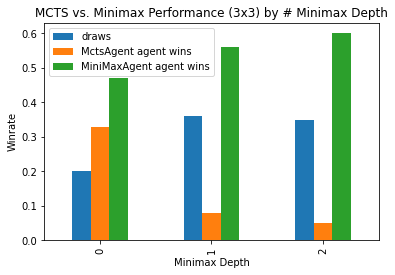

In [13]:
from eval_functions import simple_eval

depths = range(0,3)
results = []

mcts = MonteCarloAgent(num_sims=500)
for depth in depths:
    board = Board2D(board_size=3)
    mini = MiniMaxAgent(simple_eval, depth=depth)
    res = simulate(board, mcts, mini, num_sims=100, display=False)
    results.append(res)
    
plot_agent_results(
    results,
    mcts,
    mini,
    x=depths,
    title='MCTS vs. Minimax Performance (3x3) by # Minimax Depth',
    xlabel='Minimax Depth',
    ylabel='Winrate'
)

It seems that giving the minimax agent even a little bit of depth lets it dominate the MCTS agent. While the MCTS agent might be using less computational power by stochastically rolling out each state it visits, it probably ascertains a lot less information per state and therefore might not be using all the states it views as effectively as the minimax agent.

We also do the same comparison on a 3-dimensional board with the same parameters to see if this result generalizes to 3 dimensions.

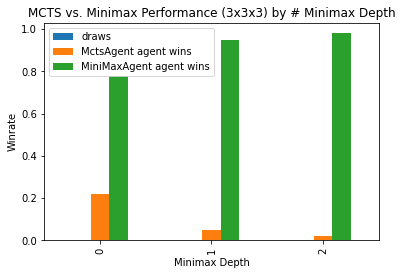

In [14]:
from tictactoe import Board3D

depths = range(0,3)
results = []

mcts = MonteCarloAgent(num_sims=500)
for depth in depths:
    board = Board3D(board_size=3)
    mini = MiniMaxAgent(simple_eval, depth=depth)
    res = simulate(board, mcts, mini, num_sims=100, display=False)
    results.append(res)
    
plot_agent_results(
    results,
    mcts,
    mini,
    x=depths,
    title='MCTS vs. Minimax Performance (3x3x3) by # Minimax Depth',
    xlabel='Minimax Depth',
    ylabel='Winrate'
)

Even on low depth, it seems that MiniMax performs significantly better than MCTS.

## Improvement

better heuristics

transpotition tables/improving tree search

RL methods

## Conclusions

here is where we restate / summarize our results

## References

hi everyone :D